In [1]:
from qiskit import qpy
from qiskit.circuit import QuantumCircuit
from qiskit.primitives import StatevectorSampler
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
import numpy as np
import matplotlib.pyplot as plt
from QuditsOnQubits import create_ame43, create_graph_ghz, create_ghz
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.transpiler import TranspilerError
from qiskit.transpiler.preset_passmanagers.plugin import list_stage_plugins

In [79]:
from qiskit_ibm_transpiler import generate_ai_pass_manager

In [69]:
def translation_opti(qc):
    list_plugins = list_stage_plugins("translation")

    list_of_best = np.zeros(len(list_plugins))
    k = 0
    pm_trans = generate_preset_pass_manager(target=target, optimization_level=3, translation_method=list_plugins[0])
    best_qc = pm_trans.run(qc)
    for name_plugin in list_plugins:
        try:
            print(f'-------- {name_plugin} --------')
            for i in range(100):
                temp_qc = pm_trans.run(qc)
                if temp_qc.depth() < best_qc.depth():
                    best_qc = temp_qc.copy()
                    list_of_best[k] = best_qc.depth()
                    print(best_qc.depth())
        except TranspilerError:
            print(f'TranspilerError {name_plugin}')
            continue
    return best_qc

In [80]:
backend = QiskitRuntimeService().backend('ibm_aachen')
target = backend.target

In [81]:
ai_transpiler_pass_manager = generate_ai_pass_manager(
    ai_optimization_level=3,
    optimization_level=3,
    ai_layout_mode="optimize",
    backend=backend,
)

In [2]:
with open('Zgate.qpy', 'rb') as fd:
    Zgate = qpy.load(fd)[0]

with open('Xgate.qpy', 'rb') as fd:
    Xgate = qpy.load(fd)[0]

with open('Fgate.qpy', 'rb') as fd:
    Fgate = qpy.load(fd)[0]

with open('CZ.qpy', 'rb') as fd:
    CZgate = qpy.load(fd)[0]

with open('FDAGgate.qpy', 'rb') as fd:
    FDAGgate = qpy.load(fd)[0]

In [7]:
Zgate_inv = Zgate.inverse()
Zgate_inv.name = "Z^-1"

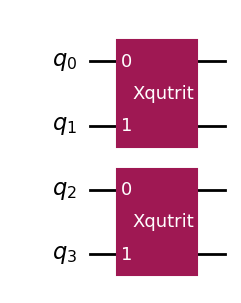

In [5]:
G1 = QuantumCircuit(4)
G1.append(Xgate, [0, 1])
G1.append(Xgate, [2, 3])
G1.draw('mpl')

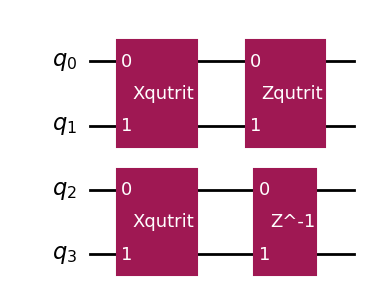

In [8]:
G1G2 = QuantumCircuit(4)
G1G2.append(Xgate, [0, 1])
G1G2.append(Zgate, [0, 1])
G1G2.append(Xgate, [2, 3])
G1G2.append(Zgate_inv, [2, 3])
G1G2.draw('mpl')

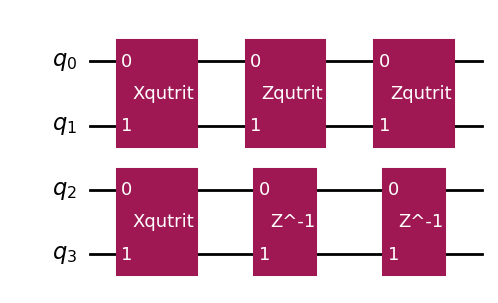

In [9]:
G1G22 = QuantumCircuit(4)
G1G22.append(Xgate, [0, 1])
G1G22.append(Zgate, [0, 1])
G1G22.append(Zgate, [0, 1])
G1G22.append(Xgate, [2, 3])
G1G22.append(Zgate_inv, [2, 3])
G1G22.append(Zgate_inv, [2, 3])
G1G22.draw('mpl')

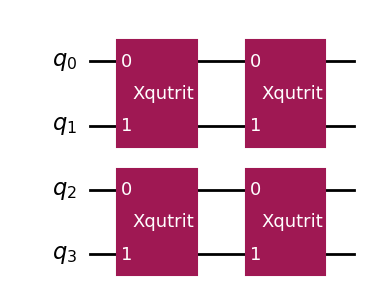

In [19]:
G1pow = QuantumCircuit(4)
G1pow.append(Xgate, [0, 1])
G1pow.append(Xgate, [0, 1])
G1pow.append(Xgate, [2, 3])
G1pow.append(Xgate, [2, 3])
G1pow.draw('mpl')

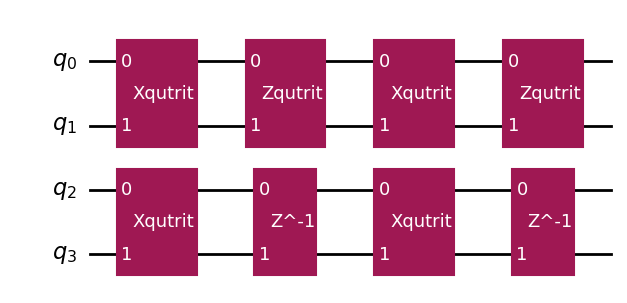

In [12]:
G1G2pow = QuantumCircuit(4)
G1G2pow.append(Xgate, [0, 1])
G1G2pow.append(Zgate, [0, 1])
G1G2pow.append(Xgate, [0, 1])
G1G2pow.append(Zgate, [0, 1])
G1G2pow.append(Xgate, [2, 3])
G1G2pow.append(Zgate_inv, [2, 3])
G1G2pow.append(Xgate, [2, 3])
G1G2pow.append(Zgate_inv, [2, 3])
G1G2pow.draw('mpl')

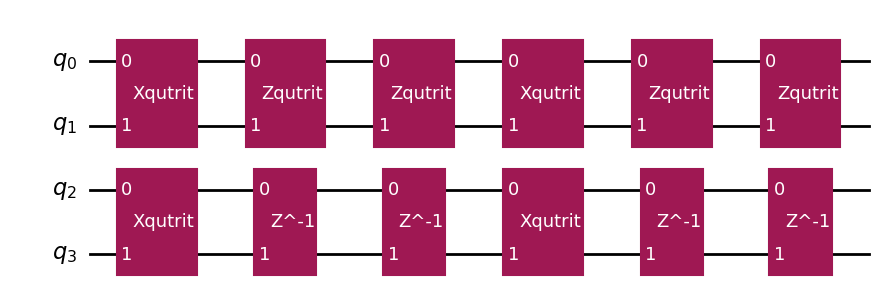

In [13]:
G1G22pow = QuantumCircuit(4)
G1G22pow.append(Xgate, [0, 1])
G1G22pow.append(Zgate, [0, 1])
G1G22pow.append(Zgate, [0, 1])
G1G22pow.append(Xgate, [0, 1])
G1G22pow.append(Zgate, [0, 1])
G1G22pow.append(Zgate, [0, 1])

G1G22pow.append(Xgate, [2, 3])
G1G22pow.append(Zgate_inv, [2, 3])
G1G22pow.append(Zgate_inv, [2, 3])
G1G22pow.append(Xgate, [2, 3])
G1G22pow.append(Zgate_inv, [2, 3])
G1G22pow.append(Zgate_inv, [2, 3])
G1G22pow.draw('mpl')

In [15]:
pm = generate_preset_pass_manager(target=target, optimization_level=3)

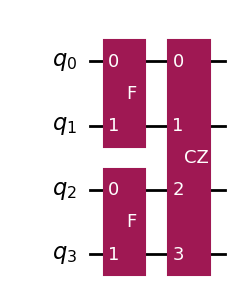

In [16]:
qc_2qutrit = QuantumCircuit(4)
qc_2qutrit.append(Fgate, [0, 1])
qc_2qutrit.append(Fgate, [2, 3])
qc_2qutrit.append(CZgate, [0, 1, 2, 3])
qc_2qutrit.draw('mpl')

In [50]:
isa_qc = pm.run(qc_2qutrit)

In [51]:
def A_operator(circ, base_qc):
    A_op = (0.5 * (Operator(circ) + Operator(circ).adjoint()))

    A = SparsePauliOp.from_operator(A_op)

    isa_2qutrit_observable_A = A.apply_layout(layout=base_qc.layout)

    return isa_2qutrit_observable_A

In [42]:
testqc = QuantumCircuit(4)
testqc.append(Xgate, [0, 1])
testqc.append(Zgate, [2, 3])

In [90]:
operators = [G1, G1G2, G1G22, G1pow, G1G2pow, G1G22pow]

operators_layout = [A_operator(op, isa_qc) for op in operators]

In [21]:
est = AerEstimator()
est.options.default_shots = 10_000

In [33]:
for op in operators_layout:
    job = est.run(isa_qc, op)
    exp_val = job.result().values[0]
    print(exp_val.round(3))

-0.029
-0.007
0.001
-0.019
0.011
-0.01
-0.011


In [34]:
Statevector(qc_2qutrit).draw('latex')

<IPython.core.display.Latex object>

In [38]:
qc_2qutrit_base = qc_2qutrit.copy()
qc_2qutrit_base.append(FDAGgate, [0, 1])
Statevector(qc_2qutrit_base).draw('latex')

<IPython.core.display.Latex object>

In [44]:
for op in operators:
    print(Statevector(qc_2qutrit_base).expectation_value(Operator(op)))

(1.9974625913725665e-16-2.92518674275801e-17j)
(1.0000000000000009-5.551115123125783e-16j)
(1.0000000000000004-4.2558549277297654e-16j)
(1.0000000000000004-3.9782991715734723e-16j)
(1.0000000000000018-1.110223024625157e-15j)
(1.000000000000001-8.234154099303246e-16j)
(1.0000000000000009-8.326672684688674e-16j)


In [49]:
isa_qc_base = pm.run(qc_2qutrit_base)

In [94]:
operators_layout_base = [[A_operator(op, isa_qc_base)] for op in operators]

In [59]:
operators_layout_base

[[SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIXIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIXIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIXIIIIIIXIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIZIIIIIIXIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIYIIIIIIYII

In [ ]:
job = est.run(isa_qc_base, [operators_layout_base])
exp_val = job.result().values[0]
print(exp_val.round(3))

In [56]:
for op in operators_layout_base:
    job = est.run(isa_qc_base, op)
    exp_val = job.result().values[0]
    print(exp_val.round(3))

0.001
1.017
0.98
1.018
0.957
0.972
1.021


In [63]:
estimator = Estimator(mode=backend)
backend.name

'ibm_aachen'

In [64]:
pub = (isa_qc_base, operators_layout_base)
job_result_2qutrit = estimator.run(pubs=[pub]).result()


In [65]:
job_result_2qutrit[0].data.evs

array([[-0.00113235],
       [ 0.95108061],
       [ 0.94047938],
       [ 0.92028312],
       [ 0.95108061],
       [ 0.94047938],
       [ 0.92028312]])

In [66]:
exp_vals = job_result_2qutrit[0].data.evs[1:]
exp_vals

array([[0.95108061],
       [0.94047938],
       [0.92028312],
       [0.95108061],
       [0.94047938],
       [0.92028312]])

Bell operator value

In [68]:
isa_qc_base.depth()

87

In [82]:
op_isa = translation_opti(qc_2qutrit_base)

-------- default --------
-------- synthesis --------
-------- translator --------
-------- ibm_backend --------
-------- ibm_dynamic_circuits --------
-------- ibm_fractional --------


In [67]:
sum(exp_vals)

array([5.62368622])

In [71]:
from qiskit.transpiler.passes.scheduling import (
    ALAPScheduleAnalysis,
    PadDynamicalDecoupling,
)
from qiskit.transpiler import PassManager
from qiskit.visualization import timeline_drawer
from qiskit.circuit.library import XGate, YGate
from qiskit.transpiler import InstructionProperties
from qiskit.circuit.equivalence_library import (
    SessionEquivalenceLibrary as sel,
)
from qiskit.transpiler.passes import BasisTranslator

In [72]:
X = XGate()
Y = YGate()

dd_sequence = [X, Y, X, Y]

In [73]:
target = backend.target

basis_gates = list(target.operation_names)
basis_gates

['delay', 'sx', 'measure', 'id', 'rz', 'cz', 'x', 'reset']

In [74]:
y_gate_properties = {}
for qubit in range(target.num_qubits):
    y_gate_properties.update(
        {
            (qubit,): InstructionProperties(
                duration=target["x"][(qubit,)].duration,
                error=target["x"][(qubit,)].error,
            )
        }
    )

target.add_instruction(YGate(), y_gate_properties)

In [75]:
dd_pm = PassManager(
    [
        ALAPScheduleAnalysis(target=target),
        PadDynamicalDecoupling(target=target, dd_sequence=dd_sequence),
    ]
)

In [76]:
isa_qc_base_dd = dd_pm.run(isa_qc_base)

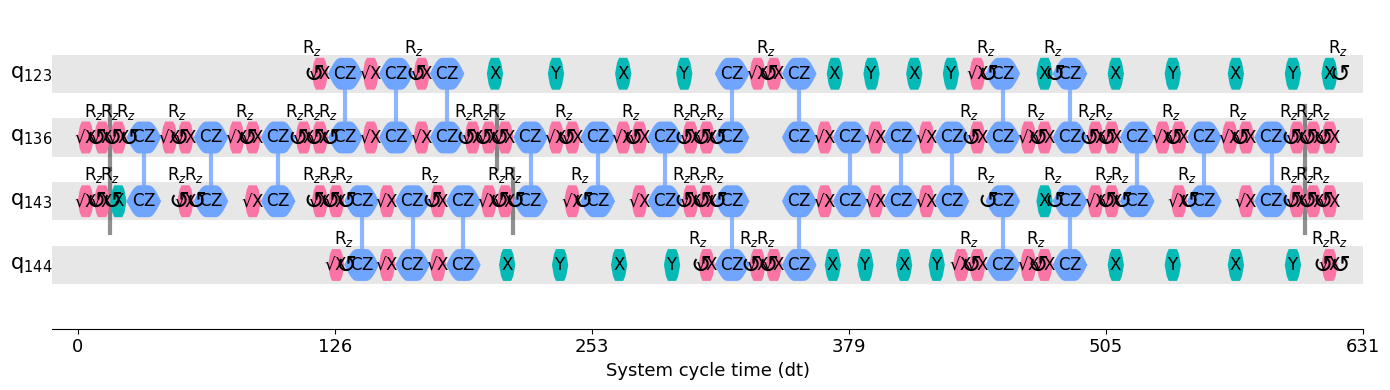

In [77]:
timeline_drawer(isa_qc_base_dd, idle_wires=False, target=target)

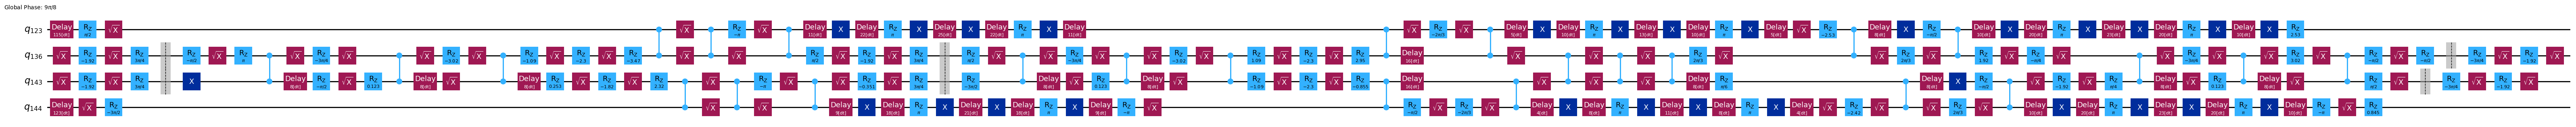

In [78]:
isa_qc_base_dd = BasisTranslator(sel, basis_gates)(isa_qc_base_dd)
isa_qc_base_dd.draw("mpl", fold=-1, idle_wires=False)

In [84]:
best_ai_isa_qc = ai_transpiler_pass_manager.run(qc_2qutrit_base)

for i in range(100):
    best_ai_isa_qc2 = ai_transpiler_pass_manager.run(qc_2qutrit_base)
    if best_ai_isa_qc2.depth() <= best_ai_isa_qc.depth():
        best_ai_isa_qc = best_ai_isa_qc2.copy()
        print(best_ai_isa_qc2.depth())

85
85
85
85
85
85


In [85]:
best_ai_isa_qc.depth()

85

In [91]:
operators_layout_base_ai = [[A_operator(op, best_ai_isa_qc)] for op in operators]

In [87]:
isa_qc_base_ai_dd = dd_pm.run(best_ai_isa_qc)

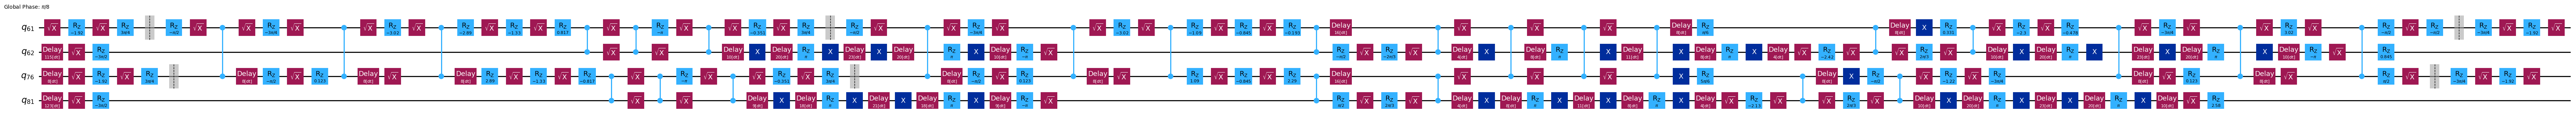

In [88]:
isa_qc_base_ai_dd = BasisTranslator(sel, basis_gates)(isa_qc_base_ai_dd)
isa_qc_base_ai_dd.draw("mpl", fold=-1, idle_wires=False)

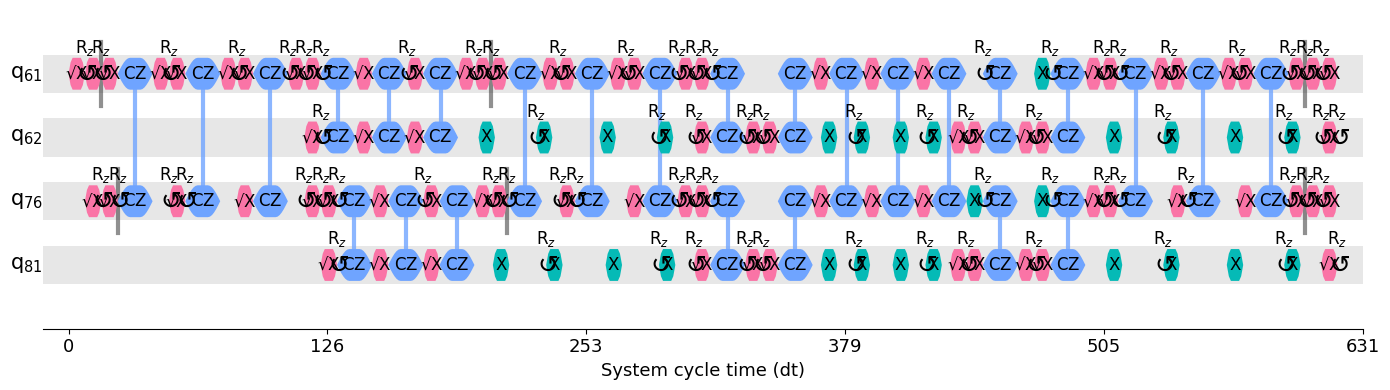

In [89]:
timeline_drawer(isa_qc_base_ai_dd, idle_wires=False, target=target)

In [93]:
pub_ai = (best_ai_isa_qc, operators_layout_base_ai)
job_result_2qutrit_ai = estimator.run(pubs=[pub_ai]).result()

In [95]:
pub_dd = (isa_qc_base_dd, operators_layout_base)
job_result_2qutrit_dd = estimator.run(pubs=[pub_dd]).result()

In [96]:
pub_ai_dd = (isa_qc_base_ai_dd, operators_layout_base_ai)
job_result_2qutrit_ai_dd = estimator.run(pubs=[pub_ai_dd]).result()

In [97]:
job_result_2qutrit_ai[0].data.evs

array([[0.86892608],
       [0.86379742],
       [0.84730867],
       [0.86892608],
       [0.86379742],
       [0.84730867]])

In [98]:
job_result_2qutrit_dd[0].data.evs

array([[0.95128665],
       [0.91771331],
       [0.90962196],
       [0.95128665],
       [0.91771331],
       [0.90962196]])

In [99]:
job_result_2qutrit_ai_dd[0].data.evs

array([[0.8616216 ],
       [0.84207537],
       [0.87067707],
       [0.8616216 ],
       [0.84207537],
       [0.87067707]])

In [100]:
from qiskit_ibm_transpiler.transpiler_service import TranspilerService

In [103]:
cloud_transpiler_service = TranspilerService(
    ai="false",
    optimization_level=3,
)

In [104]:
transpiled_circuit = cloud_transpiler_service.run(qc_2qutrit_base)

ERROR:backoff:Giving up _request_transp(...) after 3 tries (requests.exceptions.HTTPError: 503 Server Error: Service Unavailable for url: https://cloud-transpiler.quantum.ibm.com/transpile?optimization_level=3&ai=false)
ERROR:qiskit_ibm_transpiler.wrappers.base:Service temporarily unavailable. 


TranspilerError: 'Service temporarily unavailable. '